In [194]:
import os
import math
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [195]:
def recreate_folder():
    # Path of the folder to be removed
    folder_path = 'data/train'
    # Remove the folder and its subfolders
    shutil.rmtree(folder_path)
    # Create the new folder and its subfolders
    os.makedirs(os.path.join(folder_path, 'fea_sample'))

In [196]:
def show_graph_info(graph):
    # Compute the number of nodes and edges of the graph
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    # Compute in-degree and out-degree of each node
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    # Compute average in-degree and out-degree
    avg_in_degree = sum(in_degrees.values()) / len(in_degrees)
    avg_out_degree = sum(out_degrees.values()) / len(out_degrees)
   # Create a table with the graph information
    table = [
        ["Number of nodes", num_nodes],
        ["Number of edges", num_edges],
        ["Average in-degree", f"{avg_in_degree:.2f}"],
        ["Average out-degree", f"{avg_out_degree:.2f}"]
    ]
    # Print the table
    print(tabulate(table, headers=["Metrices", "Value"]))


In [197]:
class feature_extractor():
    def __init__(self, df, graph):
        self.df = df
        # self.graph = self.get_graph()
        self.graph = graph
        self.wcc = list(nx.weakly_connected_components(self.graph))

    def get_graph(self):
        # Sample the edges
        tmp = self.df.copy()
        if {'label'}.issubset(tmp.columns):
            df_sample = tmp[tmp['label'] == 1]
        else:
            df_sample = tmp
        graph = nx.DiGraph()
        # Add edges to graph
        for i, row in df_sample.iterrows():
            graph.add_edge(row['node1'], row['node2'])
        return graph

    def get_features(self):
        df_tmp = self.df.copy()
        pr, mean_pr = self.get_pr()
        katz, mean_katz = self.get_katz()
        hubs, authorities = self.get_hits()
        
        dc = nx.degree_centrality(self.get_graph())
        bc = nx.betweenness_centrality(self.get_graph())
        cc = nx.clustering(self.get_graph())

        centrality_measures = [
            ('dc', dc),
            ('bc', bc),
            ('cc', cc)
        ]

        for col_name, metrics in centrality_measures:
            df_tmp[f'{col_name}_node1'] = df_tmp.apply(
                lambda row: metrics.get(row['node1'], 0), axis=1)
            
            df_tmp[f'{col_name}_node2'] = df_tmp.apply(
                lambda row: metrics.get(row['node2'], 0), axis=1)

        (df_tmp['num_followers_s'], df_tmp['num_followers_d'],
         df_tmp['num_followees_s'], df_tmp['num_followees_d'],
         df_tmp['inter_followers'], df_tmp['inter_followees']) = self.compute_features_stage1()


        # Define the column names and corresponding functions
        features_stage2 = [
            ('jaccard_followers', self.jaccard_for_followers),
            ('jaccard_followees', self.jaccard_for_followees),
            ('cosine_followers', self.cosine_for_followers),
            ('cosine_followees', self.cosine_for_followees),
            ('adar_index', self.calc_adar_in),
            ('follows_back', self.follows_back),
            ('same_comp', self.belongs_to_same_wcc),
            ('shortest_path', self.compute_shortest_path_length)
        ]

        # Apply the functions to the train and test dataframes
        for col_name, func in features_stage2:
            df_tmp[col_name] = df_tmp.apply(lambda row: func(
                row['node1'], row['node2']), axis=1)

        features_stage3 = {
            'page_rank': lambda x: pr.get(x, mean_pr),
            'katz': lambda x: katz.get(x, mean_katz),
            'hubs': lambda x: hubs.get(x, 0),
            'authorities': lambda x: authorities.get(x, 0)
        }

        # Apply each function to the source and destination nodes in the train and test dataframes
        for feature_name, feature_func in features_stage3.items():
            df_tmp[f'{feature_name}_s'] = df_tmp['node1'].apply(feature_func)
            df_tmp[f'{feature_name}_d'] = df_tmp['node2'].apply(feature_func)

        return df_tmp

    def compute_features_stage1(self):
        # calculating no of followers followees for source and destination
        # calculating intersection of followers and followees for source and destination
        num_followers_s = []
        num_followees_s = []
        num_followers_d = []
        num_followees_d = []
        inter_followers = []
        inter_followees = []

        for i, row in self.df.iterrows():
            s1 = set(self.graph.predecessors(row['node1'])) if self.graph.has_node(
                row['node1']) else set()
            s2 = set(self.graph.successors(row['node1'])) if self.graph.has_node(
                row['node1']) else set()
            d1 = set(self.graph.predecessors(row['node2'])) if self.graph.has_node(
                row['node2']) else set()
            d2 = set(self.graph.successors(row['node2'])) if self.graph.has_node(
                row['node2']) else set()

            num_followers_s.append(len(s1))
            num_followees_s.append(len(s2))
            num_followers_d.append(len(d1))
            num_followees_d.append(len(d2))
            inter_followers.append(len(s1.intersection(d1)))
            inter_followees.append(len(s2.intersection(d2)))

        return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

    # For followees
    def jaccard_for_followees(self, a, b):
        try:
            if len(set(self.graph.successors(a))) == 0 | len(set(self.graph.successors(b))) == 0:
                return 0
            sim = (len(set(self.graph.successors(a)).intersection(set(self.graph.successors(b))))) /\
                (len(set(self.graph.successors(a)).union(set(self.graph.successors(b)))))
        except:
            return 0
        return sim

    # For followers
    def jaccard_for_followers(self, a, b):
        try:
            if len(set(self.graph.predecessors(a))) == 0 | len(set(self.graph.predecessors(b))) == 0:
                return 0
            sim = (len(set(self.graph.predecessors(a)).intersection(set(self.graph.predecessors(b))))) /\
                (len(set(self.graph.predecessors(a)).union(
                    set(self.graph.predecessors(b)))))
            return sim
        except:
            return 0

    # For followees
    def cosine_for_followees(self, a, b):
        try:
            if len(set(self.graph.successors(a))) == 0 | len(set(self.graph.successors(b))) == 0:
                return 0
            sim = (len(set(self.graph.successors(a)).intersection(set(self.graph.successors(b))))) /\
                (math.sqrt(len(set(self.graph.successors(a)))
                           * len((set(self.graph.successors(b))))))
            return sim
        except:
            return 0

    # For followers
    def cosine_for_followers(self, a, b):
        try:
            if len(set(self.graph.predecessors(a))) == 0 | len(set(self.graph.predecessors(b))) == 0:
                return 0
            sim = (len(set(self.graph.predecessors(a)).intersection(set(self.graph.predecessors(b))))) /\
                (math.sqrt(len(set(self.graph.predecessors(a))))
                 * (len(set(self.graph.predecessors(b)))))
            return sim
        except:
            return 0

    # Adar Index
    def calc_adar_in(self, a, b):
        sum = 0
        try:
            n = list(set(self.graph.successors(a)).intersection(
                set(self.graph.successors(b))))
            if len(n) != 0:
                for i in n:
                    if (np.log10(len(list(self.graph.predecessors(i)))) == 0):
                        sum = sum+(1/1e-15)
                    else:
                        sum = sum + \
                            (1/np.log10(len(list(self.graph.predecessors(i)))))
                return sum
            else:
                return 0
        except:
            return 0

    # Follow Back
    def follows_back(self, a, b):
        if self.graph.has_edge(b, a):
            return 1
        else:
            return 0

    # Weakly connected components
    def belongs_to_same_wcc(self, a, b):
        index = []
        if self.graph.has_edge(b, a):
            return 1
        if self.graph.has_edge(a, b):
            for i in self.wcc:
                if a in i:
                    index = i
                    break
            if (b in index):
                self.graph.remove_edge(a, b)
                if self.compute_shortest_path_length(a, b) == -1:
                    self.graph.add_edge(a, b)
                    return 0
                else:
                    self.graph.add_edge(a, b)
                    return 1
            else:
                return 0
        else:
            for i in self.wcc:
                if a in i:
                    index = i
                    break
            if (b in index):
                return 1
            else:
                return 0

   # Shortest Path
    def compute_shortest_path_length(self, a, b):
        p = -1
        try:
            if self.graph.has_edge(a, b):
                self.graph.remove_edge(a, b)
                p = nx.shortest_path_length(self.graph, source=a, target=b)
                self.graph.add_edge(a, b)
            else:
                p = nx.shortest_path_length(self.graph, source=a, target=b)
            return p
        except:
            return -1

    # Page Rank
    def get_pr(self):
        pr = nx.pagerank(self.graph, alpha=0.85)
        mean_pr = float(sum(pr.values())) / len(pr)
        print('\nPage Rank')
        print('min', pr[min(pr, key=pr.get)])
        print('max', pr[max(pr, key=pr.get)])
        print('mean', float(sum(pr.values())) / len(pr))
        return pr, mean_pr

    # Katz Centrality
    def get_katz(self):
        katz = nx.katz.katz_centrality(self.graph, alpha=0.005, beta=1)
        mean_katz = float(sum(katz.values())) / len(katz)
        print('\nKatz Centrality')
        print('min', katz[min(katz, key=katz.get)])
        print('max', katz[max(katz, key=katz.get)])
        print('mean', float(sum(katz.values())) / len(katz))
        return katz, mean_katz

    # HITS
    def get_hits(self):
        hits = nx.hits(self.graph, max_iter=100, tol=1e-08,
                       nstart=None, normalized=True)
        print('\nHITS')
        print('min', hits[0][min(hits[0], key=hits[0].get)])
        print('max', hits[0][max(hits[0], key=hits[0].get)])
        print('mean', float(sum(hits[0].values())) / len(hits[0]))
        hubs, authorities = hits
        return hubs, authorities


In [198]:
recreate_folder()

df = pd.read_csv('data/new_train_data.csv')

G = nx.from_pandas_edgelist(df[df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())

# Check original graph
show_graph_info(G)

Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17


In [199]:
# Generating missing edges from given graph
# A key-value pair represents a pair of nodes, with the value indicating the link status
# ('1' for linked and '-1' for unlinked).
edges = {}

# Loop through each row of the DataFrame
for row in df.itertuples(index=False):
    # Add the edge to the dictionary
    edges[(row[0], row[1])] = 1

# Create a set to add missing edges
missing_edges = set([])

while (len(missing_edges) < 12000):
# while (len(missing_edges) < 24000):
    a = random.randint(1, 10230)
    b = random.randint(1, 10230)
    tmp = edges.get((a, b), -1)

    # Check if the edge between them is present in the dict
    # Also, chosen nodes can't be the same
    if tmp == -1 and a != b:
        try:
            # Adding points who less likely to be friends
            if nx.shortest_path_length(G, source=a, target=b) > 2:
                # If the shortest path between two nodes is greater than two, we add them to our missing set.
                missing_edges.add((a, b))
            else:
                continue
        except:
            missing_edges.add((a, b))
    else:
        continue

print(len(missing_edges))

df_missing_edges = pd.DataFrame(list(missing_edges), columns=[
                      'node1', 'node2'])
df_missing_edges['label'] = 0

df = pd.concat([df, df_missing_edges], ignore_index=True)
print(df.shape)

12000
(36000, 3)


In [200]:
# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2)

In [201]:
def get_graph(df):
    # Sample the edges
    tmp = df.copy()
    df_sample = tmp[tmp['label'] == 1]
    graph = nx.DiGraph()
    # Add edges to graph
    for i, row in df_sample.iterrows():
        graph.add_edge(row['node1'], row['node2'])

    return graph

df_train_obj = feature_extractor(df_train, get_graph(df))
show_graph_info(df_train_obj.graph)
df_train = df_train_obj.get_features()
# print(df_train)

df_test_obj = feature_extractor(df_test, get_graph(df))
show_graph_info(df_test_obj.graph)
df_test = df_test_obj.get_features()
# print(df_test)

df_train


Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17

Page Rank
min 6.065400513331147e-05
max 0.0018194200713379078
mean 9.775171065495381e-05

Katz Centrality
min 0.00982796012312409
max 0.010901384596002185
mean 0.009886280671533283

HITS
min -6.7981134413872014e-18
max 0.008046458171009364
mean 9.775171065493643e-05
Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17

Page Rank
min 6.065400513331147e-05
max 0.0018194200713379078
mean 9.775171065495381e-05

Katz Centrality
min 0.00982796012312409
max 0.010901384596002185
mean 0.009886280671533283

HITS
min -1.3550864478153932e-18
max 0.008046458171009357
mean 9.775171065493637e-05


,node1,node2,label,dc_node1,dc_node2,bc_node1,bc_node2,cc_node1,cc_node2,num_followers_s,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
30145,447,7304,0,0.000000,0.000115,0.000000e+00,0.000000e+00,0.00000,0.000000,0,...,0,-1,0.000098,0.000078,0.009886,0.009877,0.000000e+00,-0.000000e+00,0.000000e+00,-8.101820e-20
24104,531,6940,0,0.000115,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0,...,0,-1,0.000061,0.000098,0.009828,0.009886,2.078965e-20,0.000000e+00,-1.388545e-21,0.000000e+00
7458,16490,11345,0,0.000115,0.000115,0.000000e+00,0.000000e+00,0.00000,0.000000,0,...,0,-1,0.000061,0.000113,0.009828,0.009877,-1.056352e-20,-0.000000e+00,2.231755e-19,-2.405739e-21
1481,12938,8582,0,0.000807,0.001152,0.000000e+00,2.267974e-06,0.02381,0.011111,0,...,0,-1,0.000061,0.000200,0.009828,0.010178,1.292095e-18,-9.444169e-19,-1.812269e-19,-6.156259e-19
20614,9483,18636,1,0.000115,0.000230,0.000000e+00,1.328039e-08,0.00000,0.000000,0,...,0,-1,0.000061,0.000113,0.009828,0.009877,-1.803228e-22,3.911668e-21,1.625268e-19,-1.829911e-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,7581,36047,0,0.000346,0.000115,0.000000e+00,0.000000e+00,0.00000,0.000000,0,...,0,-1,0.000061,0.000113,0.009828,0.009877,-5.190917e-20,-0.000000e+00,-1.197504e-19,1.067715e-20
14132,10290,1370,0,0.000115,0.000115,0.000000e+00,0.000000e+00,0.00000,0.000000,0,...,0,-1,0.000061,0.000113,0.009828,0.009877,2.883812e-20,-0.000000e+00,-1.345047e-19,2.964622e-20
16485,8420,38806,0,0.001037,0.001498,0.000000e+00,3.390388e-06,0.00000,0.038462,1,...,0,-1,0.000066,0.000271,0.009877,0.010489,-1.501079e-18,1.802310e-03,-5.096905e-19,4.972435e-03
11377,34324,34635,0,0.000230,0.000230,1.328039e-08,0.000000e+00,0.00000,0.000000,1,...,0,-1,0.000113,0.000165,0.009877,0.009926,-2.597696e-21,-0.000000e+00,4.859929e-20,7.851904e-20


In [202]:
# df = pd.read_csv("data/Dataset_spine.csv").iloc[:, :-1]
# print(df.head())
# print(df.shape)

# df_train = pd.read_csv("data/train/train.csv")
# df_test = pd.read_csv("data/train/test.csv")
# print(df_train.head())
# print(df_train.shape)

# print(df_test.head())
# print(df_test.shape)

<Axes: xlabel='label', ylabel='count'>

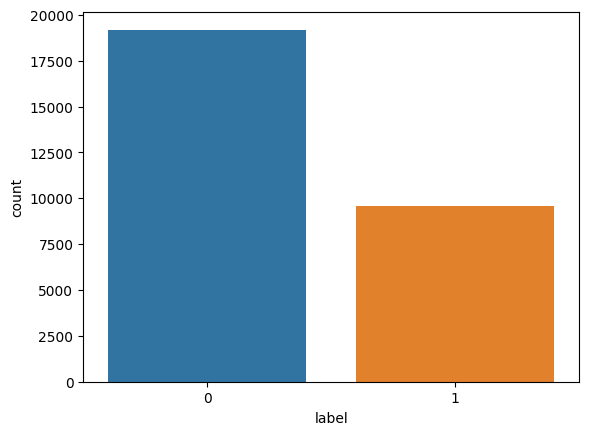

In [203]:
# sns.countplot(x='Class_att', data=df)

sns.countplot(x='label', data=df_train)


<Axes: xlabel='label', ylabel='count'>

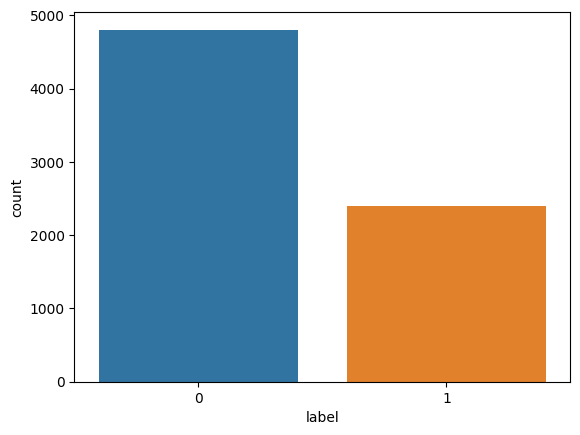

In [204]:
sns.countplot(x='label', data=df_test)


In [205]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

In [206]:
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]


In [207]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=69)

X_train = df_train.iloc[:, 3:]
X_test = df_test.iloc[:, 3:]
y_train = df_train.iloc[:, 2]
y_test = df_test.iloc[:, 2]

# print(X_train)
# print(X_test)
print(np.bincount(df_train.iloc[:, 2]))
print(np.bincount(df_test.iloc[:, 2]))


[19195  9605]
[4805 2395]


In [208]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [209]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001


In [210]:
# train data
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train),
                       torch.FloatTensor(y_train))
# test data


class TestData(Dataset):

    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)


test_data = TestData(torch.FloatTensor(X_test))


In [211]:
train_loader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)


In [212]:
class BinaryClassification(nn.Module):
    def __init__(self, input_shape):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(input_shape, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x


In [213]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
print(device)
###################### OUTPUT ######################
cuda:0

mps


In [214]:
model = BinaryClassification(input_shape=X_train.shape[1])
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (layer_1): Linear(in_features=28, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [215]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc


In [216]:
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: 0.32380 | Acc: 87.178
Epoch 002: | Loss: 0.22992 | Acc: 90.673
Epoch 003: | Loss: 0.21127 | Acc: 91.489
Epoch 004: | Loss: 0.20305 | Acc: 91.818
Epoch 005: | Loss: 0.19523 | Acc: 92.182
Epoch 006: | Loss: 0.19126 | Acc: 92.462
Epoch 007: | Loss: 0.18750 | Acc: 92.569
Epoch 008: | Loss: 0.18376 | Acc: 92.804
Epoch 009: | Loss: 0.18033 | Acc: 92.913
Epoch 010: | Loss: 0.17928 | Acc: 92.833
Epoch 011: | Loss: 0.17854 | Acc: 92.942
Epoch 012: | Loss: 0.17839 | Acc: 93.040
Epoch 013: | Loss: 0.17445 | Acc: 93.162
Epoch 014: | Loss: 0.17149 | Acc: 93.291
Epoch 015: | Loss: 0.16960 | Acc: 93.342
Epoch 016: | Loss: 0.17178 | Acc: 93.318
Epoch 017: | Loss: 0.16916 | Acc: 93.340
Epoch 018: | Loss: 0.16784 | Acc: 93.496
Epoch 019: | Loss: 0.16636 | Acc: 93.509
Epoch 020: | Loss: 0.16546 | Acc: 93.418
Epoch 021: | Loss: 0.16581 | Acc: 93.569
Epoch 022: | Loss: 0.16691 | Acc: 93.364
Epoch 023: | Loss: 0.16154 | Acc: 93.720
Epoch 024: | Loss: 0.16694 | Acc: 93.396
Epoch 025: | Los

In [217]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


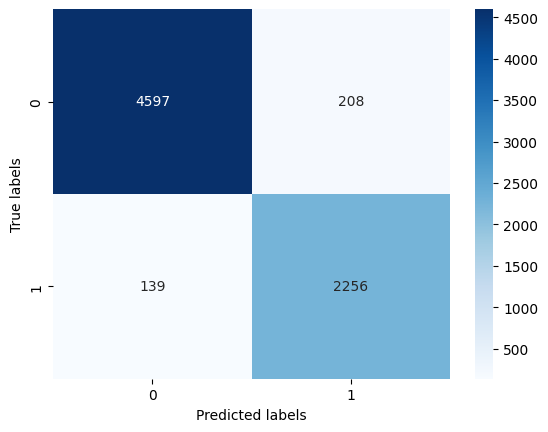

In [218]:
# assume the confusion matrix is stored in a variable called cm
cm = confusion_matrix(y_test, y_pred_list)

# create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")

# add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [219]:
report = classification_report(y_test, y_pred_list, output_dict=False)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4805
           1       0.92      0.94      0.93      2395

    accuracy                           0.95      7200
   macro avg       0.94      0.95      0.95      7200
weighted avg       0.95      0.95      0.95      7200



In [220]:
df_target = pd.read_csv('data/new_test_data.csv')
df_target_obj = feature_extractor(df_target, get_graph(df))
show_graph_info(df_target_obj.graph)
df_target = df_target_obj.get_features()

X_target = df_target.iloc[:, 3:]

scaler = StandardScaler()
X_target = scaler.fit_transform(X_target)

target_data = TestData(torch.FloatTensor(X_target))

test_loader = DataLoader(dataset=target_data, batch_size=1)
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = [int(f) for f in y_pred_list]
print(np.bincount(y_pred_list))

target_csv = 'data/sample_submit.csv'

# Load the CSV file into a Pandas DataFrame
df_target = pd.read_csv(target_csv)

# Replace the values in the 'ans' column with the values from the Python list
df_target['ans'] = y_pred_list

# Save the updated DataFrame back to a CSV file, overwriting the original file
df_target.to_csv(target_csv, index=False)


Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17

Page Rank
min 6.065400513331147e-05
max 0.0018194200713379078
mean 9.775171065495381e-05

Katz Centrality
min 0.00982796012312409
max 0.010901384596002185
mean 0.009886280671533283

HITS
min -5.436453764260916e-18
max 0.008046458171009366
mean 9.775171065493646e-05
[4888 1112]
